In [183]:
# Import necessary libraries for numerical computation and visualization
import numpy as np                                    # Numerical arrays and mathematical functions
import matplotlib.pyplot as plt                       # Plotting and visualization
import test_suite as ts                               # Test cases for hyperbolic conservation laws
import misc as mi                                     # Miscellaneous utility functions (ghost cells, boundary conditions)
import SwebySchemeTemplate as sweby                   # Sweby flux-limited scheme implementation

## Test Case Selection

**Instantiate a test** from the `test` class : 1 among 5

The test suite provides several predefined test cases for hyperbolic conservation laws:
- **Test1**: Simple advection equation with constant coefficient
- **Test2**: Nonlinear conservation law (Burgers' equation)
- **Test3**: More complex initial conditions
- **Test4**: Different boundary conditions
- **Test5**: Advanced test case

Each test contains:
- Initial condition `u0(x)`
- Flux function `f(u)`
- Characteristic speed `a(u) = df/du`
- Spatial domain and grid parameters
- Final time `tFinal`

In [184]:
# Instantiate Test1 - a basic test case for the advection equation
# This creates an object containing all problem parameters:
# - Grid spacing (dx), time step (dt), CFL number (nu)
# - Initial condition function u0(x)
# - Flux function f(u) and characteristic speed a(u)
# - Spatial domain and final time
tst = ts.Test2()

In [185]:
# Reload the module to ensure we have the latest version
import importlib
importlib.reload(sweby)

# Check the Sweby1 constructor signature
import inspect
sig = inspect.signature(sweby.Sweby1.__init__)
print("Sweby1.__init__ signature:")
print(sig)

# Check if limiter parameter exists
params = sig.parameters
if 'limiter' in params:
    print("\n✓ 'limiter' parameter is available")
    print(f"Default value: {params['limiter'].default}")
else:
    print("\n✗ 'limiter' parameter NOT found")
    print("Available parameters:", list(params.keys()))

Sweby1.__init__ signature:
(self, testCase, form='sweby', limiter='van_leer')

✓ 'limiter' parameter is available
Default value: van_leer


In [186]:
# Display the test case properties
# This will show the parameters of the selected test case:
# - Domain size, grid resolution
# - Time step and CFL condition
# - Type of PDE being solved
tst

...................................................
              Tag number : 2
              Final time : 4
                  domain : (-1.0, 1.0)
   Number of grid points : 40
                     nu  : 0.8
                     dx  : 0.05
                     dt  : 0.04
         a (wave speed)  : <function Test2.__init__.<locals>.<lambda> at 0x000001E4A7747240>

## Sweby Flux-Limited Scheme Setup

**Instantiate the `Sweby Scheme`** for the given test case

The Sweby flux-limited scheme is a high-resolution finite volume method that solves hyperbolic conservation laws of the form:

$$\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0$$

Key features:
- **High-resolution**: Combines Lax-Wendroff and Roe fluxes for accuracy and stability
- **Flux-limited**: Uses limiter functions to prevent spurious oscillations
- **TVD**: Total variation diminishing property
- **Conservative**: Exactly preserves mass/energy
- **Second-order accurate** in smooth regions, first-order near discontinuities

### Sweby Scheme Implementation

The Sweby scheme combines two fundamental approaches:

1. **Lax-Wendroff flux**: 
   - High-accuracy second-order method
   - Formula: `F_LW = (f(u_{j+1}) + f(u_j))/2 - ν/2 * A² * (u_{j+1} - u_j)`
   - Can produce oscillations near discontinuities

2. **Roe flux**: 
   - Stable first-order method
   - Formula: `F_Roe = (f(u_{j+1}) + f(u_j))/2 - |A|/2 * (u_{j+1} - u_j)`
   - Very diffusive but monotone

3. **Combined flux with limiter**:
   - Formula: `F = F_Roe + φ(r) * (F_LW - F_Roe)`
   - Limiter function φ(r) switches between methods based on local smoothness
   - Results in high accuracy in smooth regions and stability near shocks

In [187]:
# Create Sweby flux-limited scheme instance
# This initializes the high-resolution numerical solver with:
# - Test case parameters (grid, time step, etc.)
# - Sweby form (flux-limited scheme)
# - Van Leer limiter function φ(r) = (r + |r|)/(1 + |r|)
# - Combined Lax-Wendroff and Roe flux computation methods
scheme = sweby.Sweby1(tst, form='sweby', limiter='van_leer')

print(f"Sweby scheme initialized:")
print(f"- Grid spacing: {scheme.dx:.4f}")
print(f"- Time step: {scheme.dt:.4f}")
print(f"- CFL number: {scheme.nu:.4f}")
print(f"- Final time: {scheme.tFinal:.4f}")
print(f"- Limiter type: {scheme.limiter}")

# Available limiter options:
print(f"\nAvailable limiters:")
print("- 'van_leer': Balanced, smooth (default)")
print("- 'minmod': Most stable, diffusive")
print("- 'superbee': Sharpest, least diffusive")
print("- 'mc': Monotonized Central, balanced")

Sweby scheme initialized:
- Grid spacing: 0.0500
- Time step: 0.0400
- CFL number: 0.8000
- Final time: 4.0000
- Limiter type: van_leer

Available limiters:
- 'van_leer': Balanced, smooth (default)
- 'minmod': Most stable, diffusive
- 'superbee': Sharpest, least diffusive
- 'mc': Monotonized Central, balanced


## Time Integration

**Compute the evolution** of the initial condition `u0` using the Sweby flux-limited scheme

This step performs the main computation:
1. **Time-stepping loop**: Advances solution from t=0 to t=tFinal
2. **Flux computation**: Calculates Lax-Wendroff and Roe fluxes at cell interfaces
3. **Flux limiting**: Applies van Leer limiter to combine fluxes optimally
4. **Conservative update**: Uses finite volume formula: u^{n+1} = u^n - (Δt/Δx)(F_{j+1/2} - F_{j-1/2})
5. **Boundary conditions**: Handles domain boundaries via ghost cells

The scheme automatically adapts between high-order accuracy (smooth regions) and stability (near discontinuities).

In [188]:
# Run the numerical simulation from t=0 to t=tFinal
# This executes the Sweby flux-limited algorithm:
# 1. Set up initial condition with ghost cells
# 2. Loop over time steps
# 3. Compute Lax-Wendroff and Roe fluxes at interfaces
# 4. Apply van Leer limiter to combine fluxes optimally
# 5. Update cell averages using conservation law
# 6. Apply boundary conditions
# Result is stored in scheme.uF (final solution)

print("Starting computation...")
scheme.compute(scheme.tFinal)
print("Computation completed!")

# Display some solution statistics
print(f"\nSolution statistics:")
print(f"- Minimum value: {np.min(scheme.uF):.6f}")
print(f"- Maximum value: {np.max(scheme.uF):.6f}")
print(f"- Total variation: {np.sum(np.abs(np.diff(scheme.uF))):.6f}")

Starting computation...
Computation completed!

Solution statistics:
- Minimum value: -0.169978
- Maximum value: 1.172121
- Total variation: 2.806040


## Results Visualization

**Plot comparison** between analytical and numerical solutions

This visualization shows:
- **Blue line**: Exact/theoretical solution at t=tFinal (if available)
- **Orange circles**: Numerical solution computed by the Sweby flux-limited scheme
- **Dotted line**: Initial condition u₀(x) for reference

The Sweby scheme should demonstrate:
- **High accuracy**: Minimal numerical diffusion in smooth regions
- **Sharp discontinuities**: Well-resolved shocks without oscillations
- **Conservation**: Mass/energy preservation
- **TVD property**: No spurious oscillations (total variation diminishing)

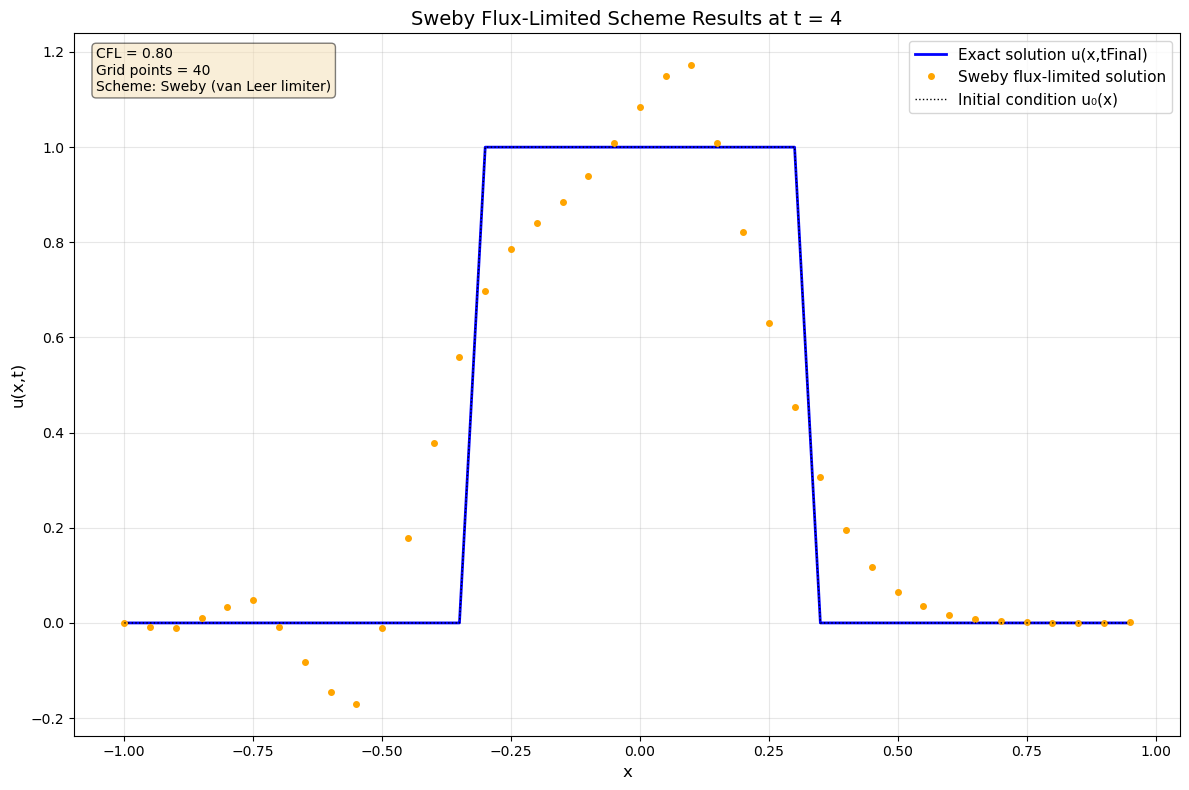

In [189]:
# Create comparison plot of solutions
plt.figure(figsize=(12, 8))

# Blue line: Exact solution at final time (if available)
if hasattr(scheme, 'uFinal') and scheme.uFinal is not None:
    plt.plot(scheme.x, scheme.uFinal, 'b-', linewidth=2, label='Exact solution u(x,tFinal)')

# Orange circles: Numerical solution from Sweby scheme
plt.plot(scheme.x, scheme.uF, 'o', color='orange', markersize=4, 
         linestyle="None", label='Sweby flux-limited solution')

# Dotted line: Initial condition for reference
plt.plot(scheme.x, scheme.u0(scheme.x), 'k:', linewidth=1, label='Initial condition u₀(x)')

# Add plot formatting
plt.xlabel('x', fontsize=12)
plt.ylabel('u(x,t)', fontsize=12)
plt.title(f'Sweby Flux-Limited Scheme Results at t = {scheme.tFinal}', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Add text box with scheme information
textstr = f'CFL = {scheme.nu:.2f}\nGrid points = {len(scheme.x)}\nScheme: Sweby (van Leer limiter)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()